![NWU logo](NWUlogo.png)

***


# Exam 1

|      |      |
|:--- |:--- |
| Date | 2024-06-06 |
|Duration  | 2 weeks |
|Examiner | Pieter van Vuuren |
|Internal moderator | Prof Alwyn Hoffman |
|External moderator | Dr. Rensu Theart |

### Instructions
* This is a take-home, computer-based assignment.
* **This assignment is not group-work.** Bear in mind that you will also have to pass an oral examination during which you'll have to prove that you have done your own work in this assignment.
* **Steer clear of single-line solutions.** Your Python code should be as detailed as the code that we have developed during the class work and tutorials. As an example, we employed multiple lines of code in class to design Butterworth filters. In constrast the SciPy library solves the same problem in a single line of code, namely: `scipy.signal.butter()`. The latter approach won't earn you any credit in this assignment. Similarly "design" of an FIR filter by means of `scipy.signal.remez()` also won't earn you any credit in this assignment.
* Use this notebook as foundation for your assignment report.
* Save your file in notebook format ( .ipynb) and also print it out in PDF format. 
* Submit both documents via eFundi

***

### Problem statement

The attached video shows the position of a UFO as it traversed the field of view of a camera at the limits of its magnification. Your task is to track the position of the UFO and predict its position one step (frame) ahead in the future (although 5 steps ahead in the future would even be better).


### Hints
More information on how to interpret the 2D Fourier transform of an image can be found at:
* https://plus.maths.org/content/fourier-transforms-images
* https://homepages.inf.ed.ac.uk/rbf/HIPR2/fourier.htm

Consult the following reference to read the individual frames of the video file:
* https://docs.opencv.org/4.x/dd/d43/tutorial_py_video_display.html

The position of the UFO can be modelled as a cross on the image, but also in terms of two 1D signals representing respectively the x- and y-coordinates of the center pixel of the UFO. The predicted position can therefore be represented in terms of two 1D graphs or a video showing the estimated / predicted UFO position. An easy approach to construct a video from a collection of images is by means of `ffmpeg` and more specifically as follows: 

`ffmpeg -y -framerate 10 -i /...path-to-image-folder.../image_%d.png -c:v libx264 -pix_fmt yuv420p -vf "scale=trunc(iw/2)*2:trunc(ih/2)*2" outputFileName.mp4`


### General instructions

Typically, the design of a final prediction algorithm entails the following:
1. analysis of the signal from two different perspectives;
2. a comparison of four different noise removal techniques; and
3. a comparison of two different prediction algorithms.

Be rigorous to motivate each and every design choice. Techniques should be compared on the basis of simulation results. Rigorous measurement of the efficacy of the various filtering and prediction algorithms is therefore important.

The rubricks that will be used for the assessment of your report and the oral examination are also attached to this assignment.

# Upload video and extract frames

In [109]:
import subprocess
from IPython.display import Video
from PIL import Image

# Execute ffmpeg command
# ffmpeg_command = 'ffmpeg -y -framerate 10 -i /path-to-image-folder/image_%d.png -c:v libx264 -pix_fmt yuv420p -vf "scale=2*iw:2*ih" Xfiles.mp4'
# subprocess.run(ffmpeg_command, shell=True)

# Display the video
Video("Xfiles.mp4")


In [110]:
import cv2
import os

def extract_frames(video_path, output_folder, fps):
    # Create the output directory if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Open the video file
    video = cv2.VideoCapture(video_path)
    if not video.isOpened():
        print(f"Error: Cannot open video {video_path}")
        return

    # Get the original video fps
    original_fps = video.get(cv2.CAP_PROP_FPS)
    frame_interval = int(original_fps / fps)
    
    current_frame = 0
    saved_frame = 0

    while True:
        ret, frame = video.read()
        if not ret:
            break
        
        # Save frame if it meets the interval condition
        if current_frame % frame_interval == 0:
            frame_filename = os.path.join(output_folder, f"frame_{saved_frame:04d}.png")
            cv2.imwrite(frame_filename, frame)
            saved_frame += 1
        
        current_frame += 1

    video.release()
    print(f"Extracted {saved_frame} frames to {output_folder}")

# Example usage
video_path = 'Xfiles.mp4'
output_folder = './frames/'
fps = 10  # Extract 1 frame per second

extract_frames(video_path, output_folder, fps)


Extracted 270 frames to ./frames/


# Video Analyses

## Time domain analyses

In [111]:
import cv2

def get_fps_and_resolution(video_path):
    # Open the video file
    video_capture = cv2.VideoCapture(video_path)
    
    # Get the frame rate
    fps = video_capture.get(cv2.CAP_PROP_FPS)
    
    # Get the resolution
    width = int(video_capture.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(video_capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    # Release the video capture object
    video_capture.release()
    
    return fps, (width, height)

# Example usage
video_path = 'Xfiles.mp4'
fps, resolution = get_fps_and_resolution(video_path)
print("Frames per second:", fps)
print("Resolution:", resolution)

Frames per second: 10.0
Resolution: (100, 100)


From the video we can assume that every frame was captured between the same interval. 

The movement of the UFO seems to follow a circular trend, crossing over to its original position, thus modeling the position of the UFO, time is a dependant variable (frame number in our case). Furthemrore, this circular movement will result in some seasonal componenet, which need to be utilised for accurate position prediction. At the end of the video the UFO jumps from the left side of the frame to the right while dissapearing for 2 frames (Or could have been his friend xD).

Looking at the movement of the UFO, it can be noticed that the velocity as well as the acceleration is not constant. It can be seen that the UFO jumps quickly over several pixels to a position that is further away, which would have been captured with a higher frame rate. This also results in less smooth movement and could prove to be challenging for prediction. 

Contant noise exists in the background, which needs to be filtered out in order to track the UFO accurately. More on noise analyses can be found in the Fast fourier transform section below, which takes a look at the frequency spectrum of the video.

From the code above it can be seen that the frames per second of the video is 100, and the resolution is 100x100 pixels, for a total of 270 frames (27s * 10 fps) in the video. An improvement in quality of video footage in the sense of fps and reslution, would have provided much more data and thus tracking and prediction algorithms would have been more accurate.  

## Frequency domain (FFT) analyses

Analyse several frames to compare the noise over the video, does it get better, worse or stay relatively the same?

Freq analyzes:

Al images can be represented as a combination of sinewaves. These images are represented by gratings. Gratings are effected by frequency and wavelength, and also phase. Orientation and amplitude as well.

Take the 1D FFT in col and row, also known as 2D FFT. The result of the 2 1D FFTs will provide 2 images/gratings which need to be converted as a sum of sinusoidal waves. These 1D signals can then be filtered respectively and convoluted or added up? Before IFFT is applied to show filtered image. 

Find out if conv or sum of 2 results, and also before or after IFFT.
How to convert sinusoidal gratings to 1D sinusoidal signals?

https://thepythoncodingbook.com/2021/08/30/2d-fourier-transform-in-python-and-fourier-synthesis-of-images/

From the 2D FFT the center represents the low freq and further away goes al hoe higher. Our FFT seems to have to pattern, random, noise is observed. Dots represent gratings, the brighter they are the more prominent they are in image, thus higher amplitude. Orientation of dots from centre has to do with Orientation of grating and thus phase of signal.

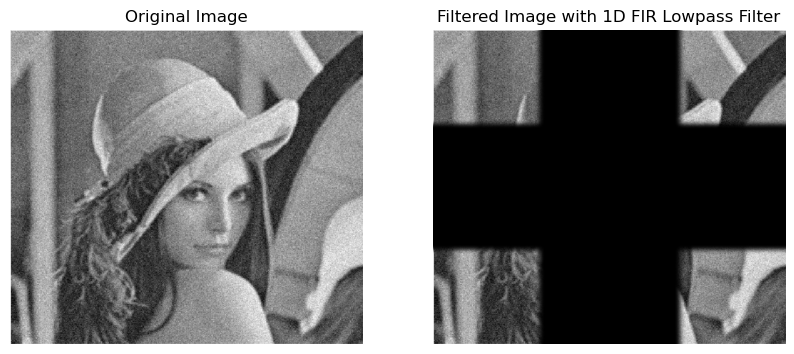

In [112]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import firwin, lfilter

def image_to_freq_signals(image_path):
    # Read the image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Take the Fourier Transform
    f_transform = np.fft.fft2(img)
    f_transform_shifted = np.fft.fftshift(f_transform)
    
    return img, f_transform_shifted

def apply_1D_fir_lowpass_filter(signal, cutoff, numtaps):
    # Design the lowpass FIR filter
    fir_coeff = firwin(numtaps, cutoff=cutoff, window='hamming', pass_zero=True)
    
    # Apply the FIR filter to the signal
    filtered_signal = lfilter(fir_coeff, 1.0, signal)
    
    return filtered_signal

def apply_filter_to_freq_signals(f_transform_shifted, cutoff, numtaps):
    height, width = f_transform_shifted.shape
    
    # Apply 1D FIR lowpass filter to rows
    filtered_transform_shifted = np.zeros_like(f_transform_shifted, dtype=complex)
    for row in range(height):
        filtered_transform_shifted[row, :] = apply_1D_fir_lowpass_filter(f_transform_shifted[row, :], cutoff, numtaps)
    
    # Apply 1D FIR lowpass filter to columns
    for col in range(width):
        filtered_transform_shifted[:, col] = apply_1D_fir_lowpass_filter(filtered_transform_shifted[:, col], cutoff, numtaps)
    
    return filtered_transform_shifted

def reconstruct_image_from_freq_signals(filtered_transform_shifted):
    # Inverse shift the Fourier transform
    filtered_transform = np.fft.ifftshift(filtered_transform_shifted)
    
    # Inverse Fourier Transform to get the image back
    filtered_image = np.fft.ifft2(filtered_transform)
    filtered_image = np.abs(filtered_image)
    
    return filtered_image

# Example usage:
image_path = "Lena_noise.jpg"
original_image, f_transform_shifted = image_to_freq_signals(image_path)

# Parameters for the FIR lowpass filter
cutoff = 0.6  # Normalized cutoff frequency (0 < cutoff < 0.5)
numtaps = 101  # Number of filter coefficients (higher number = sharper cutoff)

# Apply the FIR lowpass filter to the frequency domain signals
filtered_transform_shifted = apply_filter_to_freq_signals(f_transform_shifted, cutoff, numtaps)

# Reconstruct the filtered image
filtered_image = reconstruct_image_from_freq_signals(filtered_transform_shifted)

# Display the original and reconstructed images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_image, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(filtered_image, cmap='gray')
plt.title("Filtered Image with 1D FIR Lowpass Filter")
plt.axis('off')

plt.show()




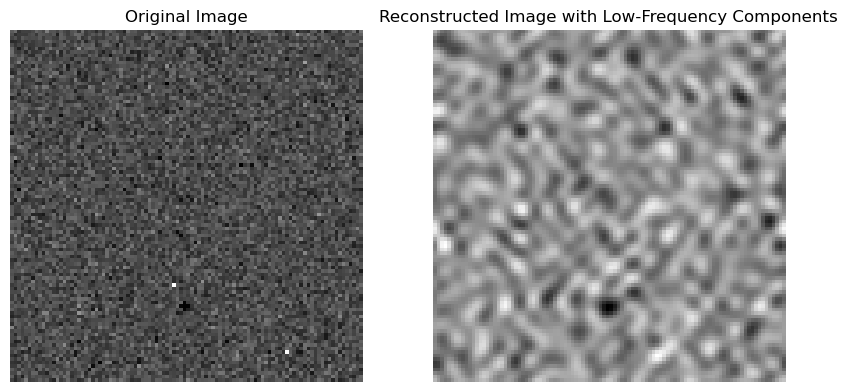

In [113]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def image_to_low_freq_image(image_path, num_components=30):
    # Read the image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Take the Fourier Transform
    f_transform = np.fft.fft2(img)
    f_transform_shifted = np.fft.fftshift(f_transform)
    
    # Create a mask for low frequencies
    mask = np.zeros_like(img, dtype=np.float32)
    center_x, center_y = mask.shape[0] // 2, mask.shape[1] // 2
    mask[center_x - num_components//2:center_x + num_components//2, 
         center_y - num_components//2:center_y + num_components//2] = 1
    
    # Apply mask to the shifted Fourier transform
    low_freq_transform_shifted = f_transform_shifted * mask
    
    # Inverse shift the Fourier transform
    low_freq_transform = np.fft.ifftshift(low_freq_transform_shifted)
    
    # Inverse Fourier Transform to get the image back
    low_freq_image = np.fft.ifft2(low_freq_transform)
    low_freq_image = np.abs(low_freq_image)
    
    return img, low_freq_image

# Example usage:
image_path = "./frames/frame_0204.png"
original_image, low_freq_image = image_to_low_freq_image(image_path)

# Display the original and reconstructed images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_image, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(low_freq_image, cmap='gray')
plt.title("Reconstructed Image with Low-Frequency Components")
plt.axis('off')

plt.show()



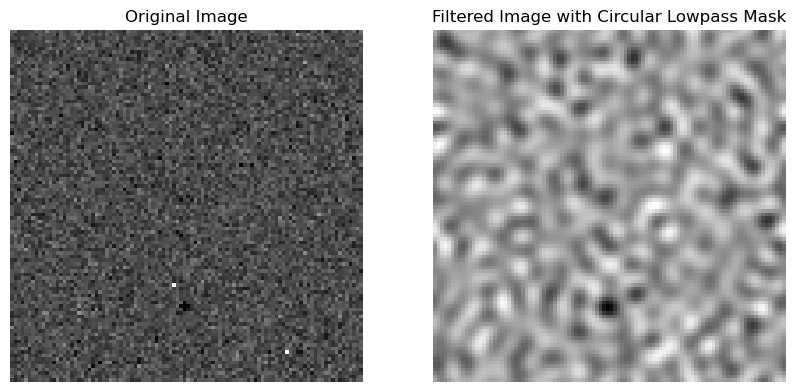

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import firwin

def image_to_freq_signals(image_path):
    # Read the image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Take the Fourier Transform
    f_transform = np.fft.fft2(img)
    f_transform_shifted = np.fft.fftshift(f_transform)
    
    return img, f_transform_shifted

def create_circular_mask(shape, cutoff_radius):
    """Creates a circular mask with the given cutoff radius."""
    rows, cols = shape
    center_x, center_y = rows // 2, cols // 2
    y, x = np.ogrid[:rows, :cols]
    distance = np.sqrt((x - center_y)**2 + (y - center_x)**2)
    mask = distance <= cutoff_radius
    return mask

def apply_circular_mask(f_transform_shifted, mask):
    return f_transform_shifted * mask

def reconstruct_image_from_freq_signals(filtered_transform_shifted):
    # Inverse shift the Fourier transform
    filtered_transform = np.fft.ifftshift(filtered_transform_shifted)
    
    # Inverse Fourier Transform to get the image back
    filtered_image = np.fft.ifft2(filtered_transform)
    filtered_image = np.abs(filtered_image)
    
    return filtered_image

# Example usage:
image_path = "./frames/frame_0204.png"
original_image, f_transform_shifted = image_to_freq_signals(image_path)

# Parameters for the FIR lowpass filter
cutoff = 0.3  # Normalized cutoff frequency (0 < cutoff < 0.5)
# numtaps = 101  # Number of filter coefficients (higher number = sharper cutoff)

# Create a 1D FIR lowpass filter
# fir_coeff = firwin(numtaps, cutoff=cutoff, window='blackman', pass_zero=True)

# Determine the cutoff radius for the circular mask
cutoff_radius = int(cutoff * min(original_image.shape) // 2)

# Create and apply the circular mask
circular_mask = create_circular_mask(f_transform_shifted.shape, cutoff_radius)
filtered_transform_shifted = apply_circular_mask(f_transform_shifted, circular_mask)

# Reconstruct the filtered image
filtered_image = reconstruct_image_from_freq_signals(filtered_transform_shifted)

# Display the original and reconstructed images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_image, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(filtered_image, cmap='gray')
plt.title("Filtered Image with Circular Lowpass Mask")
plt.axis('off')

plt.show()



In [115]:

# import numpy as np
# import matplotlib.pyplot as plt
# from PIL import Image

# # Function for the 1D FFT
# def fft_1D(x):
#     N = len(x)
#     if N <= 1:
#         return x
#     even = fft_1D(x[0::2])
#     odd = fft_1D(x[1::2])
#     T = [np.exp(-2j * np.pi * k / N) * odd[k] for k in range(N // 2)]
#     return [even[k] + T[k] for k in range(N // 2)] + \
#            [even[k] - T[k] for k in range(N // 2)]

# # Function for the 2D FFT
# def fft_2D(img):
#     x, y = np.shape(img)
#     fft2d_row = np.zeros((x, y), dtype=complex)
#     fft2d_col = np.zeros((x, y), dtype=complex)

#     for i in range(0, x):
#         fft2d_row[i, :] = fft_1D(img[i, :])
#     for i in range(0, y):
#         fft2d_col[:, i] = fft_1D(fft2d_row[:, i])

#     return fft2d_col

# # Function for FFT shift
# def fftshift_2D(img):
#     M, N = img.shape
#     shifted_img = np.zeros_like(img, dtype=img.dtype)
    
#     M_half = M // 2
#     N_half = N // 2
    
#     shifted_img[:M_half, :N_half] = img[M_half:, N_half:]
#     shifted_img[:M_half, N_half:] = img[M_half:, :N_half]
#     shifted_img[M_half:, :N_half] = img[:M_half, N_half:]
#     shifted_img[M_half:, N_half:] = img[:M_half, :N_half]
    
#     return shifted_img

# # Function to calculate the phase
# def phase(fft2d):
#     # Get image shape
#     M, N = fft2d.shape
#     # Create empty output array
#     output = np.zeros((M, N), dtype=float)
#     # Loop over all pixels of the output array
#     for u in range(M):
#         for v in range(N):
#             # Calculate the output value
#             output[u, v] = np.arctan2(fft2d[u, v].imag, fft2d[u, v].real)
#     return output

# # Load the image
# img_path = 'Lena_noise.jpg' # Update this path to your image
# image = Image.open(img_path).convert('L')  # Convert image to grayscale
# image_array = np.array(image)

# # Perform 2D FFT
# fft2d_result = fft_2D(image_array)
# fft2d_shifted = fftshift_2D(fft2d_result)  # Shift the zero frequency component to the center

# # Compute magnitude spectrum
# magnitude_spectrum = 20 * np.log10(np.abs(fft2d_shifted) + 1)  # Use log scale for better visualization

# # Compute phase
# phase_result = np.unwrap(np.angle(fft2d_shifted))

# # Plot the original image and the FFT result
# plt.figure(figsize=(18, 6))

# plt.subplot(1, 3, 1)
# plt.title('Original Image')
# plt.imshow(image_array, cmap='gray')
# plt.axis('off')

# plt.subplot(1, 3, 2)
# plt.title('Magnitude Spectrum')
# plt.imshow(magnitude_spectrum, cmap='gray')
# plt.axis('off')

# plt.subplot(1, 3, 3)
# plt.title('Phase')
# plt.imshow(phase_result, cmap='gray')
# plt.axis('off')

# plt.show()


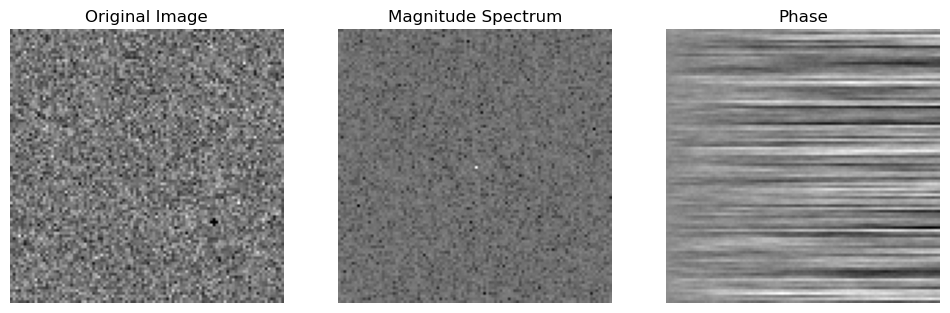

In [116]:
# Load the image
# img_path = './frames/frame_0000.png'
import numpy as np
from matplotlib import pyplot as plt
img_path = './frames/frame_0010.png'
image = Image.open(img_path)

# Convert image to grayscale
image_gray = image.convert('L')

# Convert image to numpy array
image_array = np.array(image_gray)

# Perform 2D FFT
fft2d = np.fft.fft2(image_array)
fft2d_shifted = np.fft.fftshift(fft2d)  # Shift the zero frequency component to the center

# Compute magnitude spectrum
magnitude_spectrum = 20*np.log10(np.abs(fft2d_shifted))  # Use log scale for better visualization
phase = np.unwrap(np.angle(fft2d_shifted))

# Plot the original image and the FFT result
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(image_array, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Magnitude Spectrum')
plt.imshow(magnitude_spectrum, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Phase')
plt.imshow(phase, cmap='gray')
plt.axis('off')

plt.show()

c:\Users\User\miniconda3\envs\signal3\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\User\miniconda3\envs\signal3\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


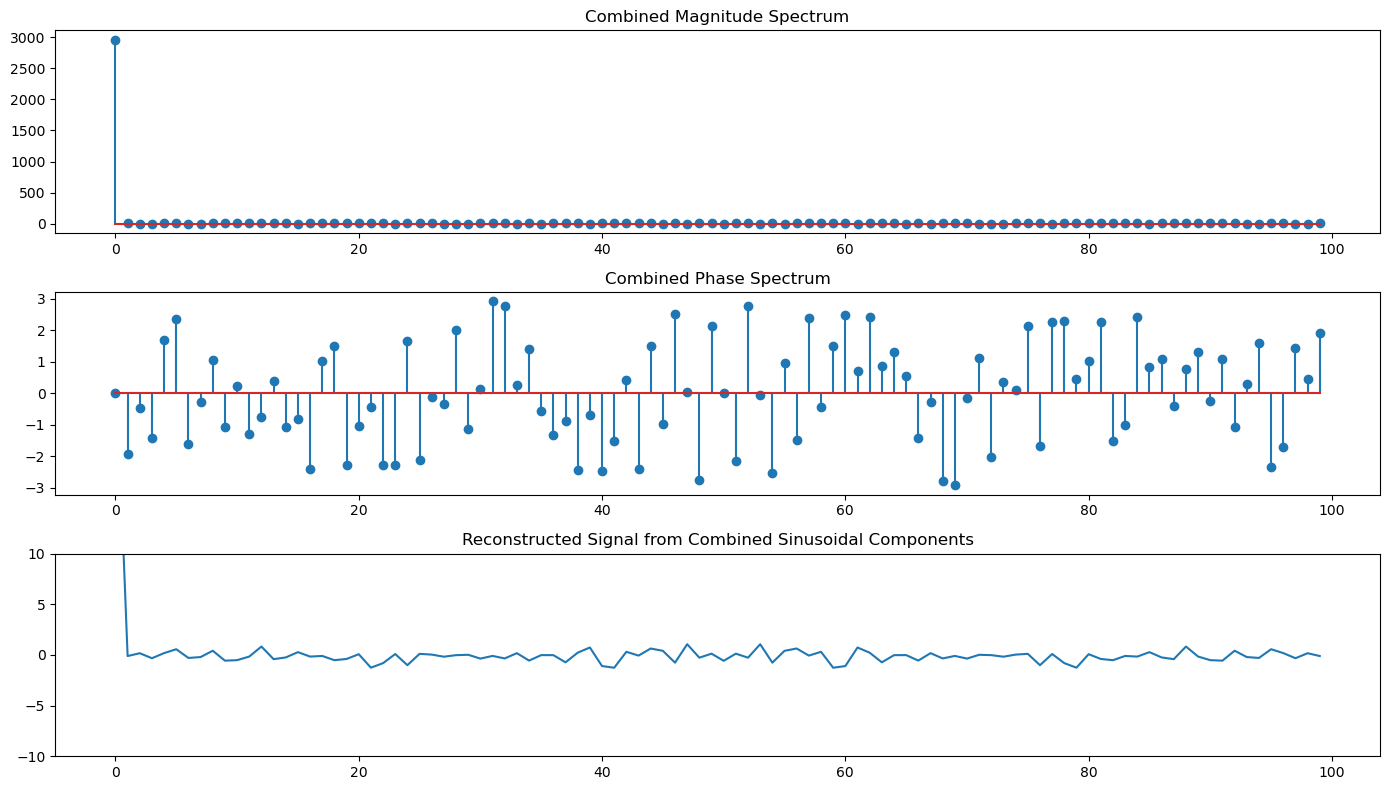

In [117]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft

# Load the grayscale image
image = plt.imread('./frames/frame_0000.png')
if image.ndim == 3:  # Convert to grayscale if it's a color image
    image = np.mean(image, axis=2)

# Initialize the combined frequency components
combined_f_transform = None

# Apply 1D FFT to each row and sum the frequency components
for row in image:
    f_transform = fft(row)
    if combined_f_transform is None:
        combined_f_transform = f_transform
    else:
        combined_f_transform += f_transform

# Get the magnitude and phase of the combined frequency components
combined_magnitude = np.abs(combined_f_transform)
combined_phase = np.angle(combined_f_transform)

# Reconstruct the combined signal using inverse FFT
reconstructed_signal = ifft(combined_f_transform).real

# Plot the results
plt.figure(figsize=(14, 8))

# Plot the magnitude spectrum of the combined frequency components
plt.subplot(3, 1, 1)
plt.title('Combined Magnitude Spectrum')
plt.stem(combined_magnitude)

# Plot the phase spectrum of the combined frequency components
plt.subplot(3, 1, 2)
plt.title('Combined Phase Spectrum')
plt.stem(combined_phase)

# Plot the reconstructed combined signal
plt.subplot(3, 1, 3)
plt.title('Reconstructed Signal from Combined Sinusoidal Components')
plt.plot(f_transform)
plt.ylim(-10,10)

plt.tight_layout()
plt.show()



C:\Users\User\AppData\Local\Temp\ipykernel_693668\899183736.py:64: RuntimeWarning: divide by zero encountered in log10
  plt.plot(10 * np.log10(np.abs(filtered_combined_f_transform)))


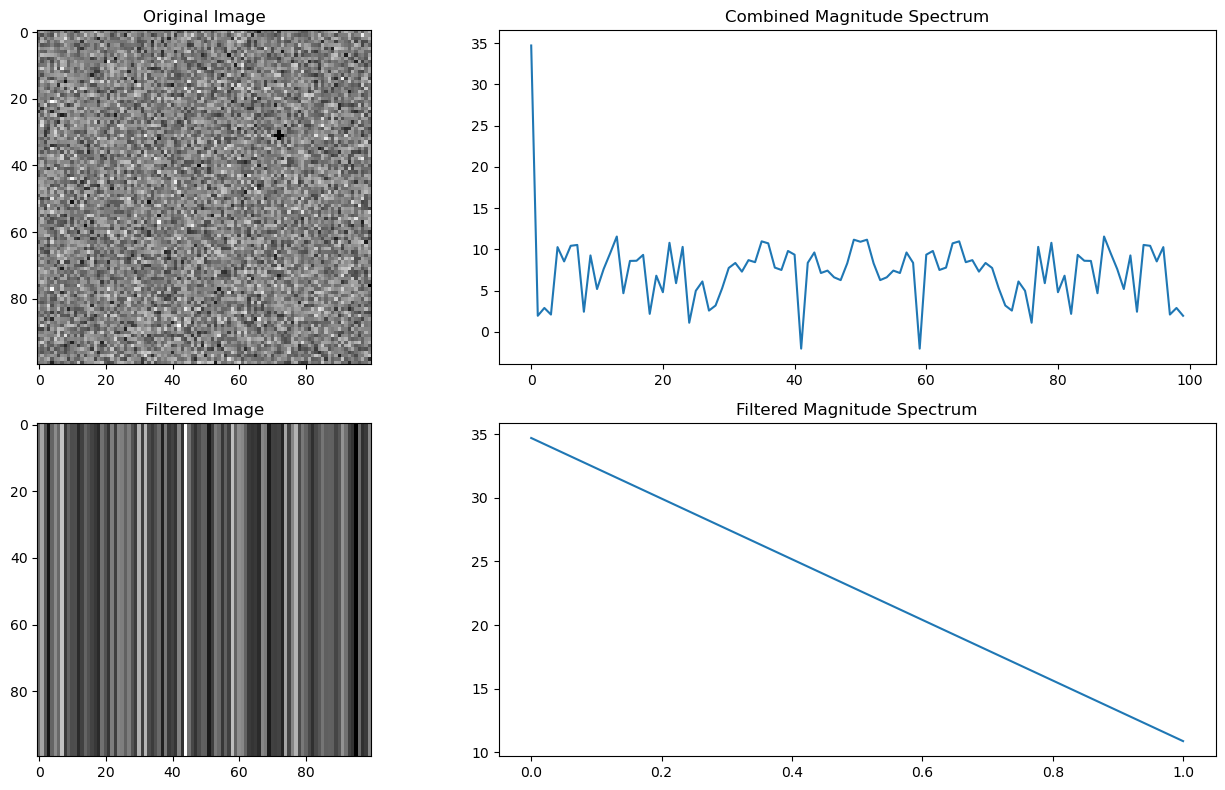

In [118]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft
from scipy.ndimage import uniform_filter1d

# Load the grayscale image
image = plt.imread('./frames/frame_0080.png')
if image.ndim == 3:  # Convert to grayscale if it's a color image
    image = np.mean(image, axis=2)

# Get the dimensions of the image
rows, cols = image.shape

# Initialize the combined frequency components
combined_f_transform = np.zeros(cols, dtype=complex)

# Apply 1D FFT to each row and sum the frequency components
for row in image:
    f_transform = fft(row)
    combined_f_transform += f_transform

# # Apply a low-pass filter to the combined frequency components
# cutoff = 2  # You can adjust the cutoff frequency
# filter_mask = np.zeros(cols)
# filter_mask[:cutoff] = 1

# Apply a moving average filter to the reconstructed signal
window_size = 1  # You can adjust the window size
smoothed_signal = uniform_filter1d(combined_f_transform, size=window_size)

# filtered_combined_f_transform = combined_f_transform * filter_mask

# Perform inverse FFT on the filtered signal to reconstruct the signal
filtered_reconstructed_signal = ifft(smoothed_signal).real



# Map the smoothed signal back to the rows of the image
smoothed_image = np.zeros((rows, cols))
for i in range(rows):
    smoothed_image[i, :] = filtered_reconstructed_signal

# Plot the results
plt.figure(figsize=(14, 8))

# Plot the original image
plt.subplot(2, 2, 1)
plt.title('Original Image')
plt.imshow(image, cmap='gray')

# Plot the combined magnitude spectrum of the original image
plt.subplot(2, 2, 2)
plt.title('Combined Magnitude Spectrum')
plt.plot(10 * np.log10(np.abs(combined_f_transform)))

# Plot the filtered image
plt.subplot(2, 2, 3)
plt.title('Filtered Image')
plt.imshow(smoothed_image, cmap='gray')

# Plot the combined magnitude spectrum of the filtered signal
plt.subplot(2, 2, 4)
plt.title('Filtered Magnitude Spectrum')
plt.plot(10 * np.log10(np.abs(filtered_combined_f_transform)))

plt.tight_layout()
plt.show()



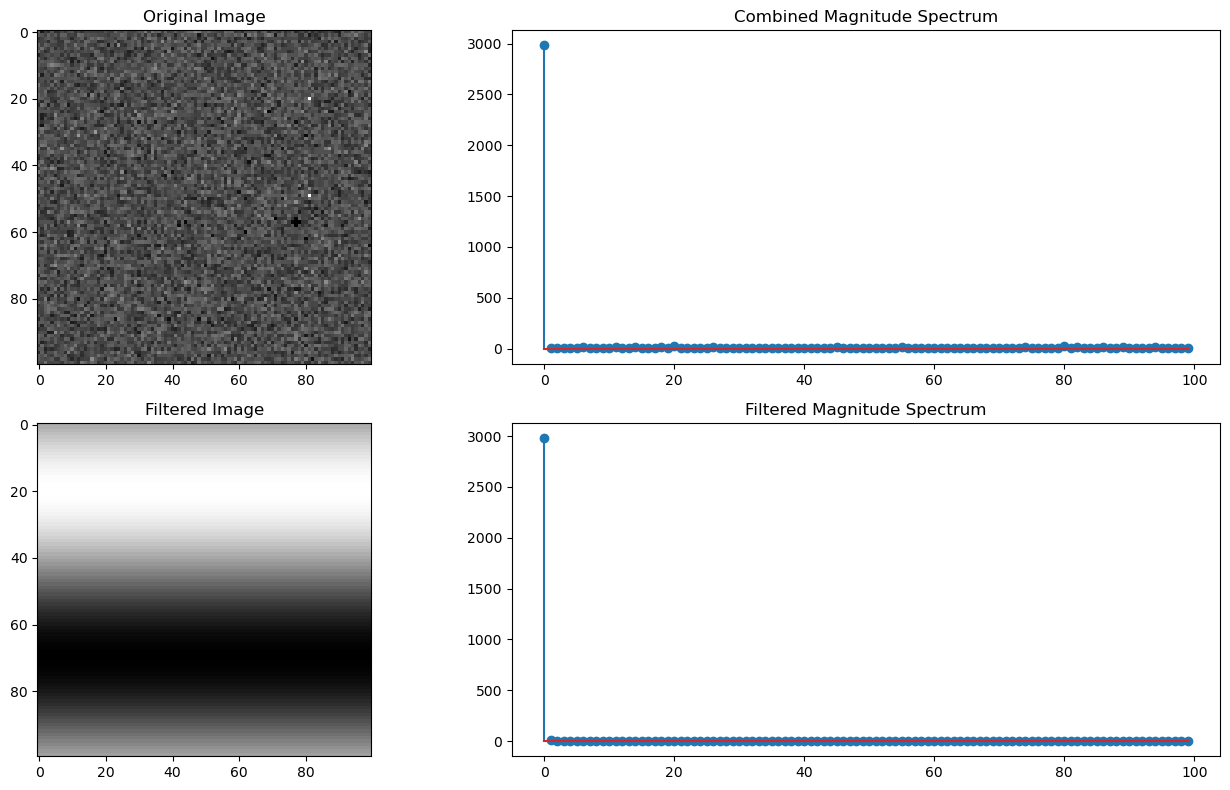

In [119]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft, fftshift, ifftshift

# Load the grayscale image
image = plt.imread('./frames/frame_0004.png')
if image.ndim == 3:  # Convert to grayscale if it's a color image
    image = np.mean(image, axis=2)

# Get the dimensions of the image
# rows, cols = image.shape

# Initialize the combined frequency components
combined_f_transform = np.zeros(rows, dtype=complex)

# Apply 1D FFT to each column and sum the frequency components
for col in range(cols):
    f_transform = fft(image[:, col])
    combined_f_transform += f_transform

# Apply a low-pass filter to the combined frequency components
cutoff = 2  # You can adjust the cutoff frequency
filter_mask = np.zeros(rows)
filter_mask[:cutoff] = 1
# filter_mask[-cutoff:] = 1

filtered_combined_f_transform = combined_f_transform * filter_mask

# Perform inverse FFT on the filtered signal to reconstruct the signal
filtered_reconstructed_signal = ifft(filtered_combined_f_transform).real

# Map the filtered reconstructed signal back to the columns of the image
filtered_image = np.zeros((rows, cols))
for col in range(cols):
    filtered_image[:, col] = ifft(filtered_combined_f_transform).real

# Plot the results
plt.figure(figsize=(14, 8))

# Plot the original image
plt.subplot(2, 2, 1)
plt.title('Original Image')
plt.imshow(image, cmap='gray')

# Plot the combined magnitude spectrum of the original image
plt.subplot(2, 2, 2)
plt.title('Combined Magnitude Spectrum')
plt.stem(np.abs(combined_f_transform))

# Plot the filtered image
plt.subplot(2, 2, 3)
plt.title('Filtered Image')
plt.imshow(filtered_image, cmap='gray')

# Plot the combined magnitude spectrum of the filtered signal
plt.subplot(2, 2, 4)
plt.title('Filtered Magnitude Spectrum')
plt.stem(np.abs(filtered_combined_f_transform))

plt.tight_layout()
plt.show()


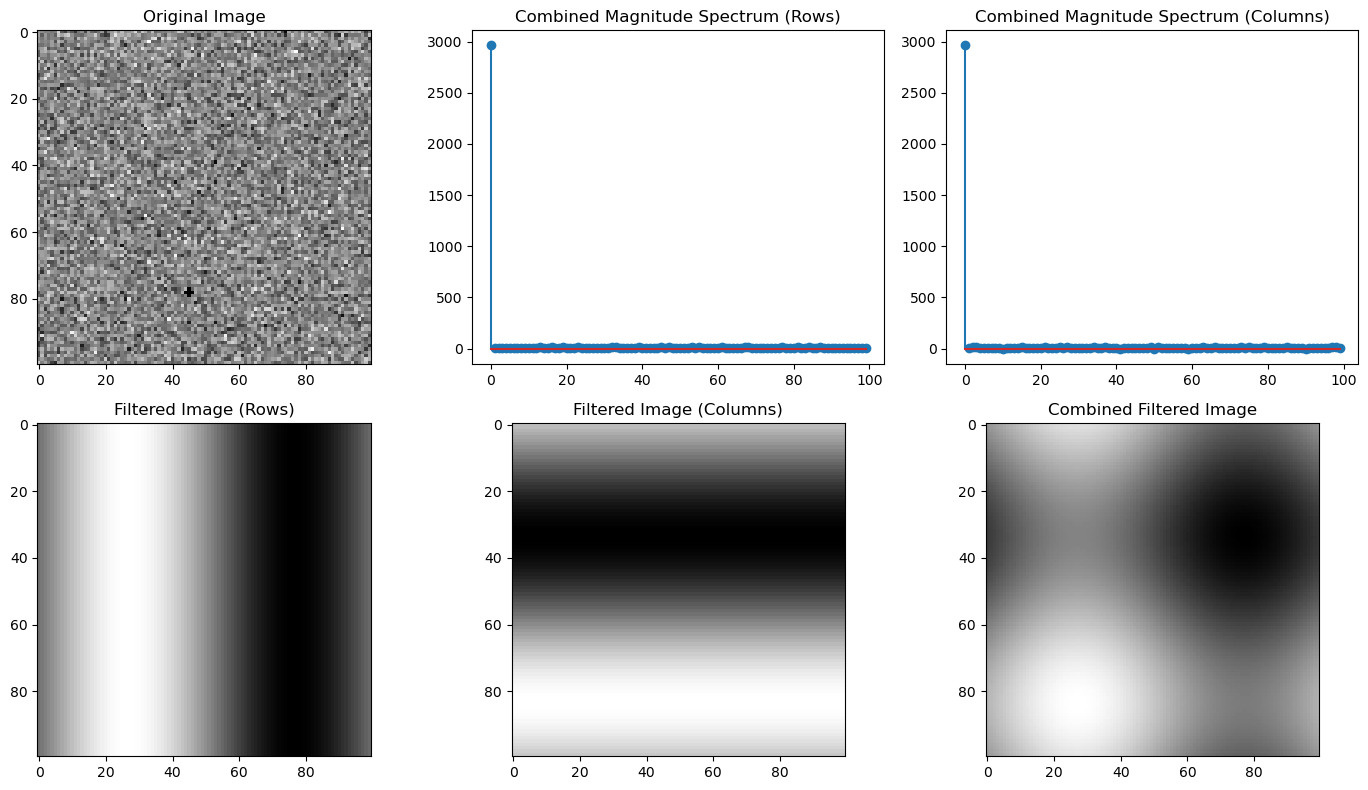

In [120]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft, fftshift, ifftshift
from scipy.signal import convolve2d

# Load the grayscale image
# image = plt.imread('grayscale_image.png')
image = plt.imread('./frames/frame_0025.png')
if image.ndim == 3:  # Convert to grayscale if it's a color image
    image = np.mean(image, axis=2)

# Get the dimensions of the image
rows, cols = image.shape

# Initialize the combined frequency components for rows and columns
combined_f_transform_rows = np.zeros(cols, dtype=complex)
combined_f_transform_cols = np.zeros(rows, dtype=complex)

# Apply 1D FFT to each row and sum the frequency components
for row in image:
    f_transform = fft(row)
    combined_f_transform_rows += f_transform

# Apply 1D FFT to each column and sum the frequency components
for col in range(cols):
    f_transform = fft(image[:, col])
    combined_f_transform_cols += f_transform

# Apply a low-pass filter to the combined frequency components for rows
cutoff = 2  # You can adjust the cutoff frequency
filter_mask_rows = np.zeros(cols)
filter_mask_rows[:cutoff] = 1
# filter_mask_rows[-cutoff:] = 1

filtered_combined_f_transform_rows = combined_f_transform_rows * filter_mask_rows

# Apply a low-pass filter to the combined frequency components for columns
filter_mask_cols = np.zeros(rows)
filter_mask_cols[:cutoff] = 1
# filter_mask_cols[-cutoff:] = 1

filtered_combined_f_transform_cols = combined_f_transform_cols * filter_mask_cols


# Reconstruct the filtered signals using inverse FFT
filtered_reconstructed_signal_rows = ifft(filtered_combined_f_transform_rows).real
filtered_reconstructed_signal_cols = ifft(filtered_combined_f_transform_cols).real

# Map the filtered reconstructed signals back to the rows and columns of the image
filtered_image_rows = np.zeros((rows, cols))
for i in range(rows):
    filtered_image_rows[i, :] = ifft(filtered_combined_f_transform_rows).real

filtered_image_cols = np.zeros((rows, cols))
for col in range(cols):
    filtered_image_cols[:, col] = ifft(filtered_combined_f_transform_cols).real

# Combine the filtered row and column images
filtered_image_combined = (filtered_image_rows * filtered_image_cols)


# Plot the results
plt.figure(figsize=(14, 8))

# Plot the original image
plt.subplot(2, 3, 1)
plt.title('Original Image')
plt.imshow(image, cmap='gray')

# Plot the magnitude spectrum of the combined frequency components for rows
plt.subplot(2, 3, 2)
plt.title('Combined Magnitude Spectrum (Rows)')
plt.stem(np.abs(combined_f_transform_rows))

# Plot the magnitude spectrum of the combined frequency components for columns
plt.subplot(2, 3, 3)
plt.title('Combined Magnitude Spectrum (Columns)')
plt.stem(np.abs(combined_f_transform_cols))

# Plot the filtered image from rows
plt.subplot(2, 3, 4)
plt.title('Filtered Image (Rows)')
plt.imshow(filtered_image_rows, cmap='gray')

# Plot the filtered image from columns
plt.subplot(2, 3, 5)
plt.title('Filtered Image (Columns)')
plt.imshow(filtered_image_cols, cmap='gray')

# Plot the combined filtered image
plt.subplot(2, 3, 6)
plt.title('Combined Filtered Image')
plt.imshow(filtered_image_combined, cmap='gray')

plt.tight_layout()
plt.show()


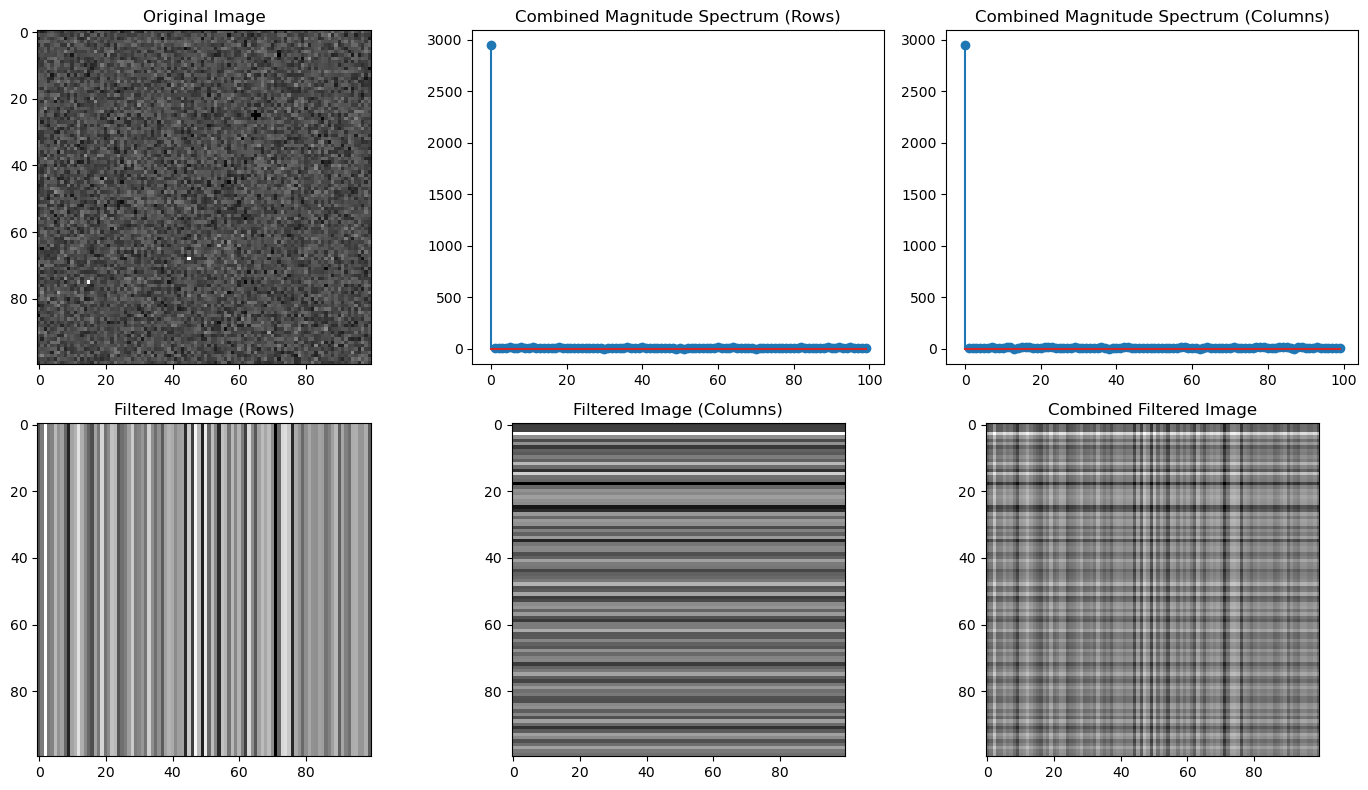

In [121]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft

# Load the grayscale image
image = plt.imread('./frames/frame_0075.png')
if image.ndim == 3:  # Convert to grayscale if it's a color image
    image = np.mean(image, axis=2)

# Get the dimensions of the image
rows, cols = image.shape

# Initialize the combined frequency components for rows and columns
combined_f_transform_rows = np.zeros(cols, dtype=complex)
combined_f_transform_cols = np.zeros(rows, dtype=complex)

# Apply 1D FFT to each row and sum the frequency components
for row in image:
    f_transform = fft(row)
    combined_f_transform_rows += f_transform

# Apply 1D FFT to each column and sum the frequency components
for col in range(cols):
    f_transform = fft(image[:, col])
    combined_f_transform_cols += f_transform

# Apply a high-pass filter to the combined frequency components for rows
cutoff = 10  # You can adjust the cutoff frequency
filter_mask_rows = np.ones(cols)
filter_mask_rows[:cutoff] = 0
filter_mask_rows[-cutoff:] = 0

filtered_combined_f_transform_rows = combined_f_transform_rows * filter_mask_rows

# Apply a high-pass filter to the combined frequency components for columns
filter_mask_cols = np.ones(rows)
filter_mask_cols[:cutoff] = 0
filter_mask_cols[-cutoff:] = 0

filtered_combined_f_transform_cols = combined_f_transform_cols * filter_mask_cols

# Reconstruct the filtered signals using inverse FFT
filtered_reconstructed_signal_rows = ifft(filtered_combined_f_transform_rows).real
filtered_reconstructed_signal_cols = ifft(filtered_combined_f_transform_cols).real

# Map the filtered reconstructed signals back to the rows and columns of the image
filtered_image_rows = np.zeros((rows, cols))
for i in range(rows):
    filtered_image_rows[i, :] = ifft(filtered_combined_f_transform_rows).real

filtered_image_cols = np.zeros((rows, cols))
for col in range(cols):
    filtered_image_cols[:, col] = ifft(filtered_combined_f_transform_cols).real

# Combine the filtered row and column images
filtered_image_combined = (filtered_image_rows + filtered_image_cols) / 2

# Plot the results
plt.figure(figsize=(14, 8))

# Plot the original image
plt.subplot(2, 3, 1)
plt.title('Original Image')
plt.imshow(image, cmap='gray')

# Plot the magnitude spectrum of the combined frequency components for rows
plt.subplot(2, 3, 2)
plt.title('Combined Magnitude Spectrum (Rows)')
plt.stem(np.abs(combined_f_transform_rows))

# Plot the magnitude spectrum of the combined frequency components for columns
plt.subplot(2, 3, 3)
plt.title('Combined Magnitude Spectrum (Columns)')
plt.stem(np.abs(combined_f_transform_cols))

# Plot the filtered image from rows
plt.subplot(2, 3, 4)
plt.title('Filtered Image (Rows)')
plt.imshow(filtered_image_rows, cmap='gray')

# Plot the filtered image from columns
plt.subplot(2, 3, 5)
plt.title('Filtered Image (Columns)')
plt.imshow(filtered_image_cols, cmap='gray')

# Plot the combined filtered image
plt.subplot(2, 3, 6)
plt.title('Combined Filtered Image')
plt.imshow(filtered_image_combined, cmap='gray')

plt.tight_layout()
plt.show()


White noise, distributed all over.

# Prediction signal analyses

The first filtering approach that was considered was to create a mask around the origin of the frequency domain, to block the higher frequencies (outside of mask) and keep the lower frequencies inside the mask. Essentially this algorithm acts as a blurring function, which will then be used togetehr with a threshold to isolate the UFO location. The results proved to be good, but a threshold could not be found that successfully finds the uFO in every frame. Some frames there are more than one pixel obove threshold, and in other no pixels above threshold.

Anothother approach was considered taht makes use of a blurring Kernel and a convolutional sum approach. This essentially moves the kernel over the image performing the convolutional operation. The kernel is overlaid onto the input image by placing its center element on each pixel of the image, one at a time. The products obtained from the element-wise multiplication are summed up to produce a single value. The resulting sum becomes the value of the output pixel at the corresponding position in the output image. The corners was chosen to make use of wrapping, and not zero padding as this interfered with the threshold algorithm. [refernec for kernel is in PCA tut]

## Time domain analyses

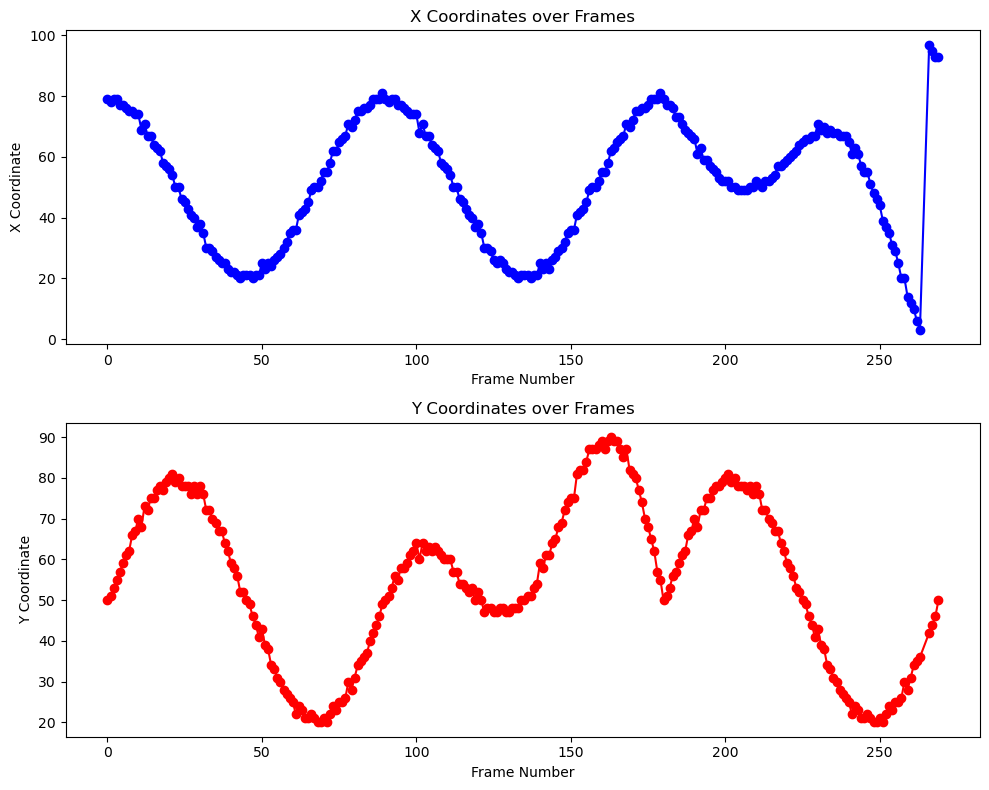

In [73]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file into a DataFrame
csv_file_path = "UFO_coordinates.csv"
df = pd.read_csv(csv_file_path)

# Create a figure and two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot the x-coordinates against frame numbers
ax1.plot(df['frame'], df['x_coord'], marker='o', linestyle='-', color='b')
ax1.set_title('X Coordinates over Frames')
ax1.set_xlabel('Frame Number')
ax1.set_ylabel('X Coordinate')

# Plot the y-coordinates against frame numbers
ax2.plot(df['frame'], df['y_coord'], marker='o', linestyle='-', color='r')
ax2.set_title('Y Coordinates over Frames')
ax2.set_xlabel('Frame Number')
ax2.set_ylabel('Y Coordinate')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

In [77]:
from IPython.display import HTML

video_path = "UFO_tracking.mp4"  # Replace "your_video.mp4" with the path to your MP4 video file

HTML(f"""
<video width="640" height="480" controls>
  <source src="{video_path}" type="video/mp4">
</video>
""")


## Frequency domain analyses

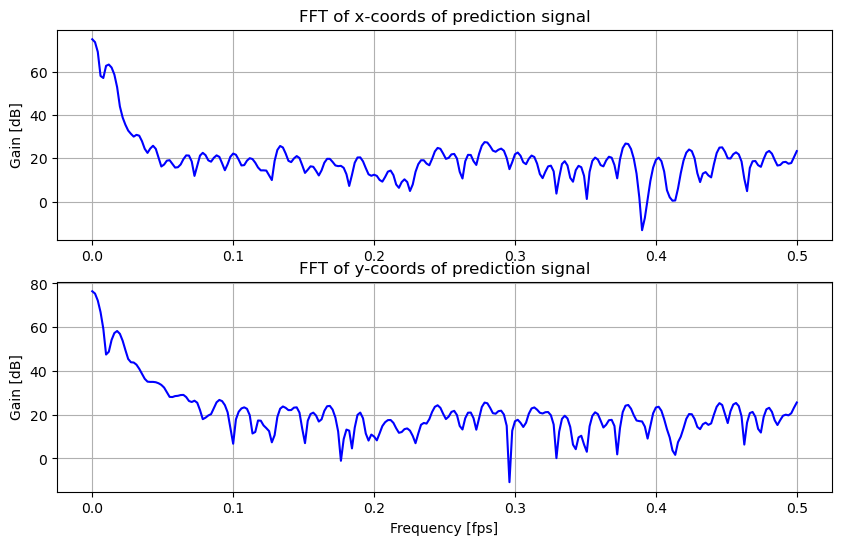

In [74]:
from scipy import signal as sig
# Assuming df['x_coord'] represents the signal
seinx = df['x_coord']
seiny = df['y_coord']

# Number of samples in the signal
N = len(seinx)

# Sampling frequency (assuming each frame corresponds to a unit time interval)
Fs = 1  # Assuming 1 frame per unit time

M = int(np.ceil(np.log2(N)))		            
Nfft = 2**M
df = Fs / Nfft

window = sig.windows.blackman(N)
X = np.fft.fft(seinx*window,Nfft)				   
X_abs = np.abs(X)					            
f = np.linspace(0,Fs/2,Nfft//2)		            

plt.figure(figsize=(10, 6))
plt.subplot(2,1,1)
plt.title('FFT of x-coords of prediction signal')
plt.plot(f[0:Nfft//2],20*np.log10(X_abs[0:Nfft//2]),'b')
# plt.xlabel('Frequency [Hz]')
plt.ylabel('Gain [dB]')
plt.grid()

# Number of samples in the signal
N = len(seiny)

# Sampling frequency (assuming each frame corresponds to a unit time interval)
Fs = 1  # Assuming 1 frame per unit time

M = int(np.ceil(np.log2(N)))		            
Nfft = 2**M
df = Fs / Nfft

window = sig.windows.blackman(N)
X = np.fft.fft(seiny*window,Nfft)				   
X_abs = np.abs(X)					            
f = np.linspace(0,Fs/2,Nfft//2)	

plt.subplot(2,1,2)
plt.title('FFT of y-coords of prediction signal')
plt.plot(f[0:Nfft//2],20*np.log10(X_abs[0:Nfft//2]),'b')
plt.xlabel('Frequency [fps]')
plt.ylabel('Gain [dB]')
plt.grid()

# Filtering techniques

## PCA

(100, 100, 3)


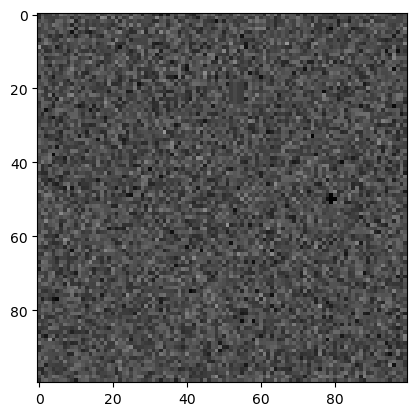

In [122]:
from matplotlib.image import imread
from matplotlib import pyplot as plt
import numpy as np

beeld = imread('./frames/frame_0000.png')
#plt.figure(figsize=[5,5])
plt.figure()
plt.imshow(beeld)
print(beeld.shape)

(100, 100)


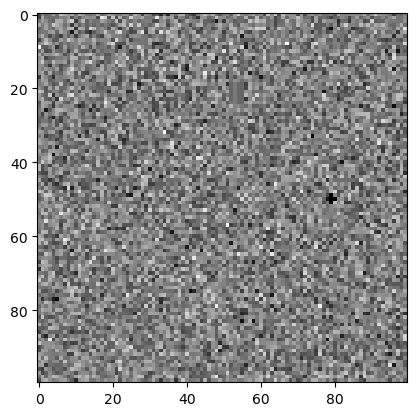

In [123]:
gray = 0.3*beeld[:,:,0] + 0.59*beeld[:,:,1] + 0.11*beeld[:,:,2]
plt.figure
plt.imshow(gray,cmap='gray')
print(gray.shape)

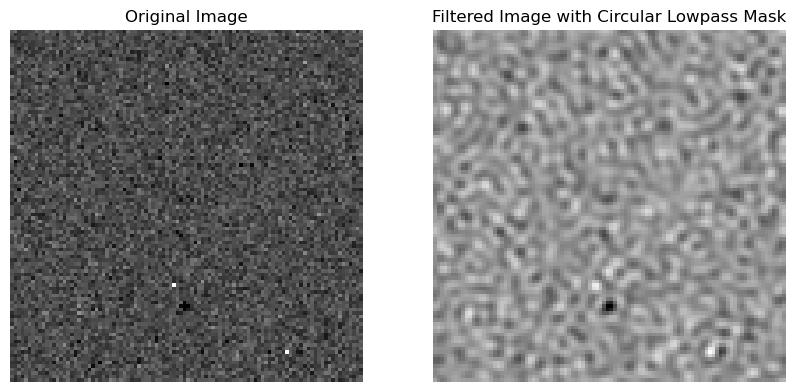

In [46]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import firwin

def image_to_freq_signals(image_path):
    # Read the image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Take the Fourier Transform
    f_transform = np.fft.fft2(img)
    f_transform_shifted = np.fft.fftshift(f_transform)
    
    return img, f_transform_shifted

def create_circular_mask(shape, cutoff_radius):
    """Creates a circular mask with the given cutoff radius."""
    rows, cols = shape
    center_x, center_y = rows // 2, cols // 2
    y, x = np.ogrid[:rows, :cols]
    distance = np.sqrt((x - center_y)**2 + (y - center_x)**2)
    mask = distance <= cutoff_radius
    return mask

def apply_circular_mask(f_transform_shifted, mask):
    return f_transform_shifted * mask

def reconstruct_image_from_freq_signals(filtered_transform_shifted):
    # Inverse shift the Fourier transform
    filtered_transform = np.fft.ifftshift(filtered_transform_shifted)
    
    # Inverse Fourier Transform to get the image back
    filtered_image = np.fft.ifft2(filtered_transform)
    filtered_image = np.abs(filtered_image)
    
    return filtered_image

# Example usage:
image_path = "./frames/frame_0204.png"
original_image, f_transform_shifted = image_to_freq_signals(image_path)

# Parameters for the FIR lowpass filter
cutoff = 0.5  # Normalized cutoff frequency (0 < cutoff < 0.5)
# numtaps = 101  # Number of filter coefficients (higher number = sharper cutoff)

# Create a 1D FIR lowpass filter
# fir_coeff = firwin(numtaps, cutoff=cutoff, window='blackman', pass_zero=True)

# Determine the cutoff radius for the circular mask
cutoff_radius = int(cutoff * min(original_image.shape) // 2)

# Create and apply the circular mask
circular_mask = create_circular_mask(f_transform_shifted.shape, cutoff_radius)
filtered_transform_shifted = apply_circular_mask(f_transform_shifted, circular_mask)

# Reconstruct the filtered image
filtered_image = reconstruct_image_from_freq_signals(filtered_transform_shifted)

# Display the original and reconstructed images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_image, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(filtered_image, cmap='gray')
plt.title("Filtered Image with Circular Lowpass Mask")
plt.axis('off')

plt.show()

blurred1 = filtered_image

In [41]:
import cv2
kernel = 1/32 * np.array([[1, 2, 1],
[2, 4, 2],
[1, 2, 1]])

blurred1 = cv2.filter2D(beeld, -1, kernel)

plt.figure(figsize=[5,5])
plt.figure(1)
plt.title('Original image 1')
plt.imshow(beeld, cmap='gray')
plt.figure(figsize=[5,5])
plt.figure(2)
plt.title('Gaussian blurred image 1')
plt.imshow(blurred1, cmap='gray')

NameError: name 'beeld' is not defined

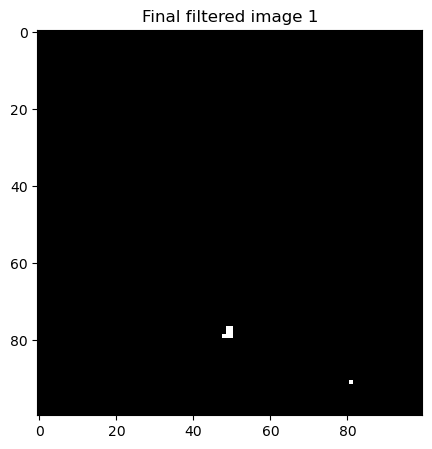

In [50]:
threshold = 40 #0.5
Filtered1 = np.where(blurred1 < threshold, 255, 0)

plt.figure(figsize=[5,5])
plt.figure(1)
plt.title('Final filtered image 1')
plt.imshow(Filtered1, cmap='gray')
gray = Filtered1

In [49]:
gray = 0.3*Filtered1[:,:,0] + 0.59*Filtered1[:,:,1] + 0.11*Filtered1[:,:,2]
plt.figure
plt.imshow(gray,cmap='gray')
print(gray.shape)

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [51]:
import numpy as np

def find_white_dot_center(image):
    # Convert the image to grayscale if it's a color image
    if len(image.shape) == 3:
        img_gray = np.mean(image, axis=2).astype(np.uint8)
    else:
        img_gray = image.astype(np.uint8)
    
    # Get the dimensions of the image
    height, width = img_gray.shape
    
    # Iterate through each pixel to find the white dot
    for y in range(height):
        for x in range(width):
            if img_gray[y, x] == 255:  # White pixel (assuming 255 is white in grayscale)
                return (x, y)  # Return the coordinates of the white dot
    
    # If no white dot is found
    return None

# Example usage
# image_path = "path_to_your_image.jpg"
# image_ndarray = np.array(Image.open(image_path))  # Load image as ndarray
white_dot_center = find_white_dot_center(gray)
if white_dot_center:
    print("Center of white dot:", white_dot_center)
else:
    print("No white dot found in the image.")


Center of white dot: (49, 77)


In [128]:
# gray = blurred1
print(gray.shape)

(100, 100)


In [129]:
#####################################____First image____##########################################################
window_size = 10 #10 first try
step = 10 

# Calculate number of windows in each dimension
num_windows_h = (gray.shape[0] - window_size) // step + 1
num_windows_w = (gray.shape[1] - window_size) // step + 1

# Initialize X matrix with zeros
X = np.zeros((window_size * window_size, num_windows_h * num_windows_w))

# Loop over each window and extract pixels
idx = 0
for i in range(num_windows_h):
    for j in range(num_windows_w):
        # Extract window of pixels
        window = gray[i*step:i*step+window_size, j*step:j*step+window_size].reshape(1, -1)
        # Stack window vector onto X matrix
        X[:,idx] = window
        idx += 1
(Nx,Ny) = X.shape
print('Dimensions of X: ')
print(X.shape)

mu = np.mean(X,1)   #calculate mean value
print('Dimension of mu: ')
print(mu.shape)

for n in range(0,Ny):   #get rid of the mean value
  X[:,n] = X[:,n] - mu

Dimensions of X: 
(100, 100)
Dimension of mu: 
(100,)


In [130]:
Cx = np.cov(X,rowvar='true')
print('Dimensions of Cx:')
print(Cx.shape)

Dimensions of Cx:
(100, 100)


In [131]:
# Obtain the eigenvalues and eigenvectors of Cx
eigval, eigvec = np.linalg.eig(Cx)
descending_indices = np.argsort(eigval)[::-1]
sorted_eigvec_descending = eigvec[:, descending_indices]
KumSom = np.cumsum(eigval)
KumSom = 100 * KumSom / np.amax(KumSom)     # normalise as a percentage
print('Dimensions of eigenvector matrix:')
print(eigvec.shape)

Dimensions of eigenvector matrix:
(100, 100)


Text(0, 0.5, 'Precentage contribution [%]')

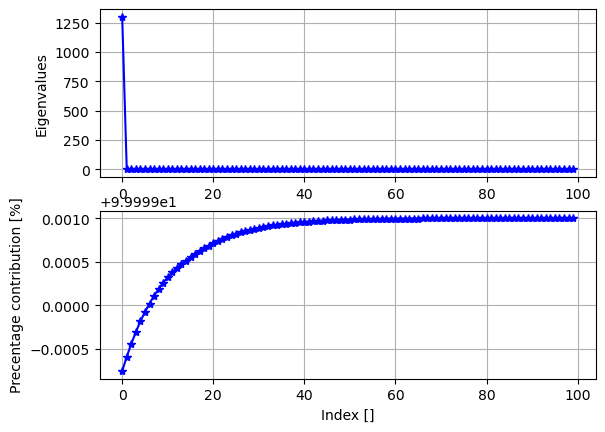

In [132]:
# Plot the scree plot
plt.figure()
plt.subplot(2,1,1)
plt.plot(eigval,'b*-')
plt.ylabel('Eigenvalues')
plt.grid()
# plt.xlim(0,10)
plt.subplot(2,1,2)
plt.plot(KumSom,'b*-')
plt.grid('true')
plt.xlabel('Index []')
plt.ylabel('Precentage contribution [%]')
# plt.xlim(0,10)

Text(0.5, 1.0, 'Eigenvectors used: 1->3')

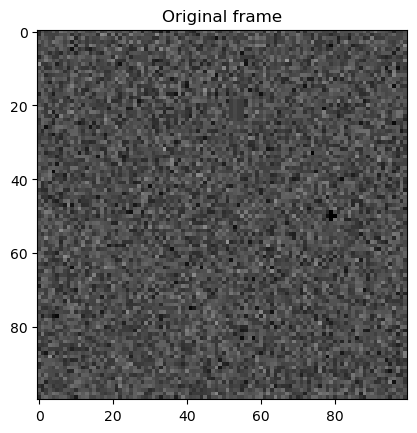

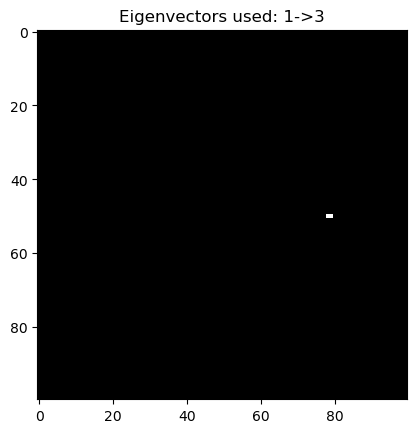

In [133]:
Nwindow = window_size**2                       # number of pixels in window

def Transform_and_Reconstruct(Nstart, Nstop):            
    
    A = np.zeros((Nwindow,Nwindow))  # construct A matrix (with eigenvectors as row vectors)
    for n in range(Nstart,Nstop):
        # A[n,:] = sorted_eigvec[:,n]
        A[n,:] = sorted_eigvec_descending[:,n]
        # print(n)
        

    y = A@X                          # transform signal

    xk = A.T @ y                     # reconstruct signal
    for n in range(0,Ny):
        xk[:,n] = xk[:,n] + mu

    out = np.zeros(gray.shape)
    k = 0
    n = 0

    for i in range(num_windows_h):
        for j in range(num_windows_w):
            out[i*step:i*step+window_size, j*step:j*step+window_size] = xk[:,k].reshape(window_size, window_size)
            k += 1

    return out

startindex = 1  #start @ 1
stopindex = 3   
image_result =  Transform_and_Reconstruct(startindex-1, stopindex)

# Plot the output
plt.figure(1)
plt.imshow(beeld, cmap = 'gray')
plt.title('Original frame')
plt.figure(2)
plt.imshow(image_result, cmap = 'gray')
plt.title('Eigenvectors used: ' + str(startindex) + '->' + str(stopindex))

In [134]:
# threshold = 0.09 #0.5
# Filtered1 = np.where(image_result < threshold, 1, image_result)

# plt.figure(figsize=[5,5])
# plt.figure(1)
# plt.title('Final filtered image 1')
# plt.imshow(Filtered1, cmap='gray')

# Prediction

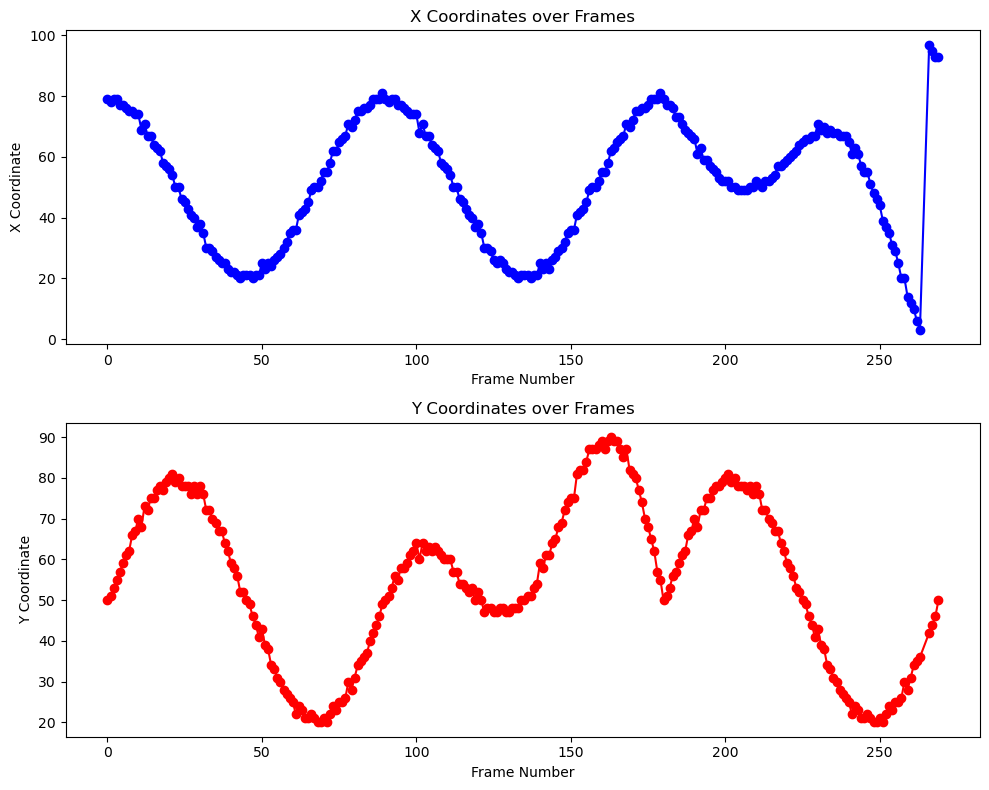

In [135]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file into a DataFrame
csv_file_path = "UFO_coordinates.csv"
df = pd.read_csv(csv_file_path)

# Create a figure and two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot the x-coordinates against frame numbers
ax1.plot(df['frame'], df['x_coord'], marker='o', linestyle='-', color='b')
ax1.set_title('X Coordinates over Frames')
ax1.set_xlabel('Frame Number')
ax1.set_ylabel('X Coordinate')

# Plot the y-coordinates against frame numbers
ax2.plot(df['frame'], df['y_coord'], marker='o', linestyle='-', color='r')
ax2.set_title('Y Coordinates over Frames')
ax2.set_xlabel('Frame Number')
ax2.set_ylabel('Y Coordinate')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

In [136]:

display(Video("UFO_tracking.mp4", embed=True))

## Kalman

Two 1D Kalman filters will be used for prediction for both the x and y coordinates. The 2D approach will not provide a very accurate representation, as the UFO travels over its original position and thus will be hard to track the prediction results of the algorithm.

Newton model is chosen, as newtonian mechanics will model movement such as acceleration and velocity better than static model.

Uncertainty in both x and y is assumed to be the same.

In [137]:
num_frames = 270
x_coords = df['x_coord']
y_coords = df['y_coord']

N_train = int(num_frames / 2)
print(f"N_train: {N_train} frames, and N_test: {num_frames-N_train} frames.")
z_train = x_coords[0:N_train]
z_test = x_coords[N_train:]

N_train: 135 frames, and N_test: 135 frames.


In [138]:
N = N_train

deltaT = 1   #arbitrarily chosen
sigma_z = np.std(z_train)
sigma_a = (sigma_z*2)/(deltaT**2)
sigma_v = sigma_a * deltaT
sigma_y = 20 #3 pixels oroginally             #motivate why (we dont yet know waht the measrement noise is, but we can model it Kalman filter close and then use the results for prediction)

z = z_train

In [139]:
Nx = 2                      # dimension of state-vector
Nz = 1                      # number of measured variables
x_est = np.zeros((Nx,N))
F = np.array([(1,deltaT),
              (0,1)])
print('F matrix:')
print('---------')
print(F)
H = np.array([1, 0])

# Reshape the array to have shape (1, 2)
H = H.reshape(1, 2) #Same as C matrix
print('H matrix:')
print('---------')
print(H)

F matrix:
---------
[[1 1]
 [0 1]]
H matrix:
---------
[[1 0]]


In [140]:
P = np.eye(Nx) * 100 #50
Q = np.array([((deltaT**4)/4,(deltaT**3)/2),
              ((deltaT**3)/2,deltaT**2)])
Q = Q * (sigma_a**2)
R = np.eye(Nz) * (sigma_y**2)

print('P matrix:')
print('---------')
print(P)
print('Q matrix:')
print('---------')
print(Q)
print('R matrix:')
print('---------')
print(R)

P matrix:
---------
[[100.   0.]
 [  0. 100.]]
Q matrix:
---------
[[ 427.43506173  854.87012346]
 [ 854.87012346 1709.74024691]]
R matrix:
---------
[[400.]]


### x-coordinates

#### fit model

(2, 1, 135)


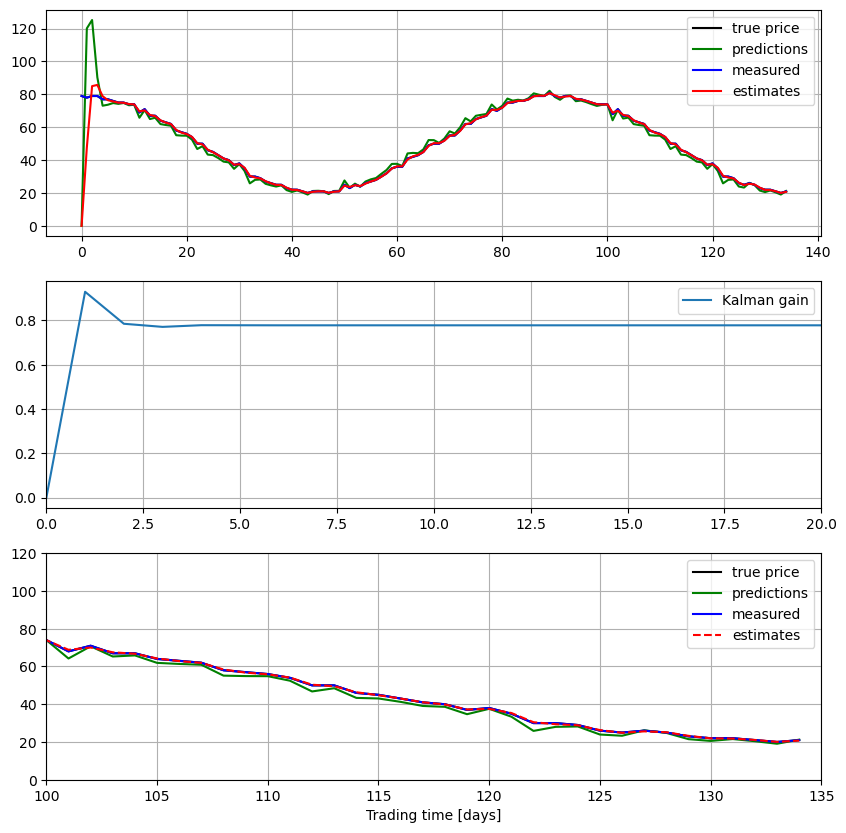

P_est : [[ 343.35788264  311.19657408]
 [ 311.19657408 1031.56706753]]


In [141]:
N = N_train
z = z_train
P_est = P
P_pred = F @ P_est @ F.T + Q
# print(P_pred.shape)
x_pred = np.zeros((Nx,N))
K = np.zeros((Nx,Nz,N))
# K = np.zeros((2,N))
I = np.eye(Nx)
for n in range(1,N):
    K[:,:,n] = P_pred @ H.T @ np.linalg.inv(H @ P_pred @ H.T + R)
    x_est[:,n] = x_pred[:,n-1] + K[:,:,n]@(z[n] - H @ x_pred[:,n-1])
    P_est = (I-K[:,:,n]@H) @ P_pred @ (I - K[:,:,n] @ H).T + (K[:,:,n] @ R @ K[:,:,n].T)
    x_pred[:,n] = F @ x_est[:,n]
    P_pred = F @ P_est @ F.T + Q



print(K.shape)

indekse = np.arange(0,N)
plt.figure(figsize=(10, 10))
plt.subplot(3,1,1)
plt.plot(indekse,z,'k-',label='true price')
plt.plot(indekse,x_pred[0,:],'g-',label='predictions')
plt.plot(indekse,z,'b-',label='measured')
plt.plot(indekse,x_est[0,:],'r-',label='estimates')
plt.grid('true')
plt.legend()
plt.subplot(3,1,2)
plt.plot(indekse,K[1,0,:], label = 'Kalman gain')
plt.xlim(0,20)
# plt.ylim(1.5,2)
plt.legend()
plt.grid('true')
plt.subplot(3,1,3)
plt.plot(indekse,z,'k-',label='true price')
plt.plot(indekse,x_pred[0,:],'g-',label='predictions')
plt.plot(indekse,z,'b-',label='measured')
plt.plot(indekse,x_est[0,:],'r--',label='estimates')
plt.xlim(100,N)
plt.ylim(0,120)
plt.legend()
plt.grid('true')
plt.xlabel('Trading time [days]')
plt.show()

print(f"P_est : {P_est}")

In [142]:
K_ss = K[1,0,len(K)]
print('Kalman gain = ', round(K_ss,4))

Kalman gain =  0.785


#### Testing model (one frame into future)

In [143]:
z = x_coords
N = z.size
print(z.size)
K = np.zeros((Nx,Nz,N))
K[1,0,:] = K_ss
K[0,0,:] = 1
# x_est_last = z_train[N-1]
# x_pred_last = z_train[N-1]

268


(2, 1, 268)


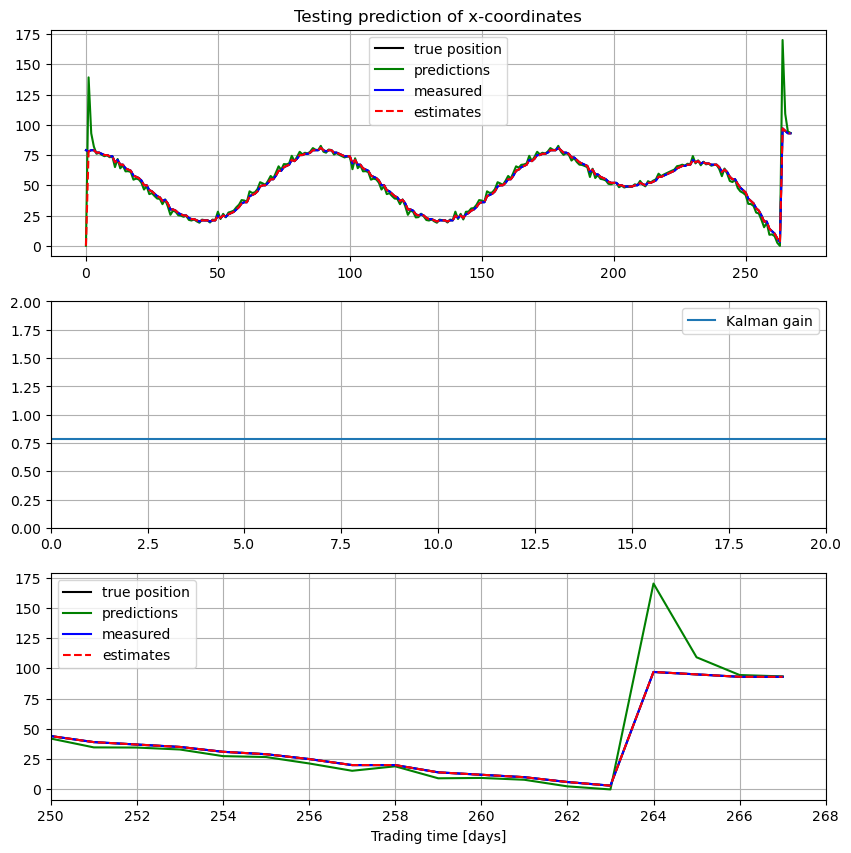

In [144]:
x_est = np.zeros((Nx,N))
x_pred = np.zeros((Nx,N))
# x_est[0,0] = x_est_last
# x_pred[0,0] = x_pred_last
I = np.eye(Nx)
for n in range(1,N):
    x_est[:,n] = x_pred[:,n-1] + K[:,:,n]@(z[n] - H @ x_pred[:,n-1])
    x_pred[:,n] = F @ x_est[:,n]



print(K.shape)

indekse = np.arange(0,N)
plt.figure(figsize=(10, 10))
plt.subplot(3,1,1)
plt.title('Testing prediction of x-coordinates')
plt.plot(indekse,z,'k-',label='true position')
plt.plot(indekse,x_pred[0,:],'g-',label='predictions')
plt.plot(indekse,z,'b-',label='measured')
plt.plot(indekse,x_est[0,:],'r--',label='estimates')
plt.grid('true')
plt.legend()

plt.subplot(3,1,2)
plt.plot(indekse,K[1,0,:], label = 'Kalman gain')
plt.xlim(0,20)
plt.ylim(0,2)
plt.legend()
plt.grid('true')

plt.subplot(3,1,3)
plt.plot(indekse,z,'k-',label='true position')
plt.plot(indekse,x_pred[0,:],'g-',label='predictions')
plt.plot(indekse,z,'b-',label='measured')
plt.plot(indekse,x_est[0,:],'r--',label='estimates')
plt.xlim(250,N)
# plt.ylim(100,300)
plt.legend()
plt.grid('true')
plt.xlabel('Trading time [days]')
plt.show()

##### Error calculations

In [145]:
# Calculate absolute and relative errors
true_values = z_test
pred_values = x_pred[0, N_train:]
est_values = x_est[0, N_train:]
abs_errors_pred = np.abs(true_values - pred_values)
abs_errors_est = np.abs(true_values - est_values)

rel_errors_pred = (abs_errors_pred / true_values) * 100
rel_errors_est = (abs_errors_est / true_values) * 100

# Print average absolute and relative errors
print("Average Absolute Error (Predictions):", round(np.mean(abs_errors_pred),2), "pixels")
print("Average Relative Error (Predictions):", round(np.mean(rel_errors_pred),2), "%")
print("Average Absolute Error (Estimates):", round(np.mean(abs_errors_est),2), "pixels")
print("Average Relative Error (Estimates):", round(np.mean(rel_errors_est),2), "%")

Average Absolute Error (Predictions): 2.12 pixels
Average Relative Error (Predictions): 5.43 %
Average Absolute Error (Estimates): 0.0 pixels
Average Relative Error (Estimates): 0.0 %


#### Testing model (5 frames into future)

In [146]:
z = x_coords
N = z.size
print(z.size)
K = np.zeros((Nx,Nz,N))
K[1,0,:] = K_ss
K[0,0,:] = 1

268


(2, 1, 268)


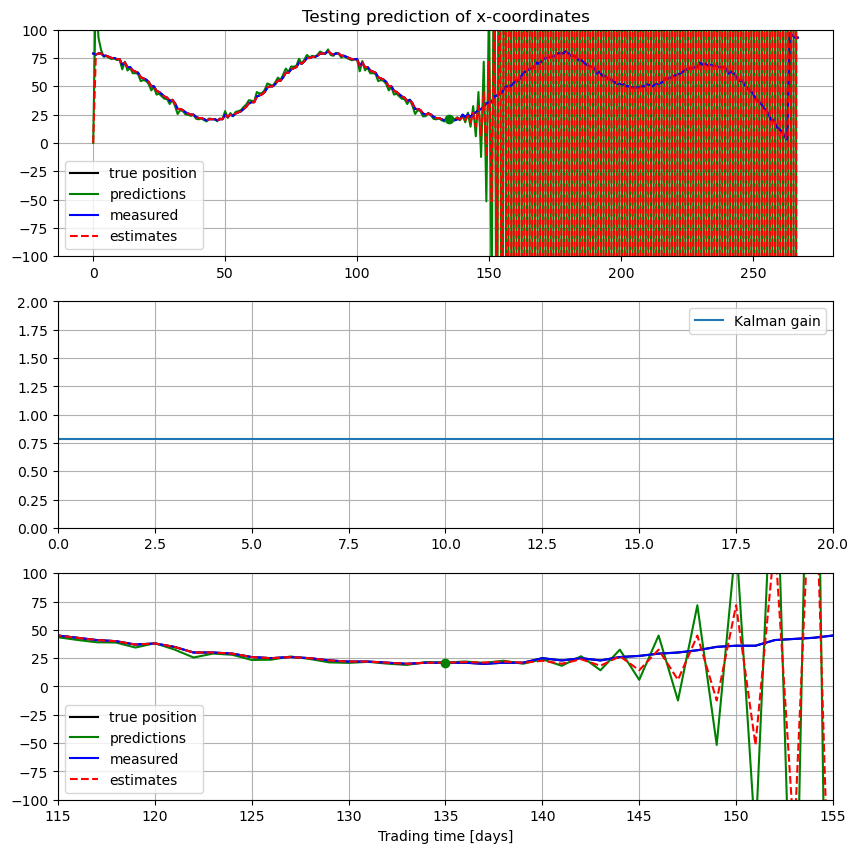

In [147]:
x_est = np.zeros((Nx,N))
x_pred = np.zeros((Nx,N))
temp_x_est = np.zeros((Nx,N))
temp_x_pred = np.zeros((Nx,N))
# temp_x_est = np.full((Nx, N), np.nan)
# temp_x_pred = np.full((Nx, N), np.nan)
I = np.eye(Nx)


# n = 1
# while n < N:
#     x_est[:,n] = x_pred[:,n-1] + K[:,:,n]@(z[n] - H @ x_pred[:,n-1])
#     x_pred[:,n] = F @ x_est[:,n]
    
#     # for k in range(n, n+5):
#     #     x_est[:,n] = x_pred[:,n-1] + K[:,:,n]@(z[n] - H @ x_pred[:,n-1])
#     #     x_pred[:,n] = F @ x_est[:,n]
#     # k = n + 1
#     n += 1
#     # x_pred[:, n] = temp_x_pred[:, n]


n = 1
while n < N:
    if ((n <= N_train)):
        # Use true values for the rest of the iterations
        x_est[:, n] = x_pred[:, n-1] + K[:, :, n] @ (z[n] - H @ x_pred[:, n-1])
    else:
        # Use previous prediction for every 5th iteration
        x_est[:, n] = x_pred[:, n-1] + K[:, :, n] @ (H @ x_pred[:, n-2] - H @ x_pred[:, n-1])
    
    x_pred[:, n] = F @ x_est[:, n]
    n += 1

    

# for n in range(1,N):
#     x_est[:,n] = x_pred[:,n-1] + K[:,:,n]@(z[n] - H @ x_pred[:,n-1])
#     x_pred[:,n] = F @ x_est[:,n]

print(K.shape)

indekse = np.arange(0,N)
plt.figure(figsize=(10, 10))
plt.subplot(3,1,1)
plt.title('Testing prediction of x-coordinates')
plt.plot(indekse,z,'k-',label='true position')
plt.plot(indekse,x_pred[0,:],'g-',label='predictions')
plt.plot(indekse,z,'b-',label='measured')
plt.plot(indekse,x_est[0,:],'r--',label='estimates')
plt.plot(N_train, z[N_train], 'go')
# plt.plot(150, z[150], 'go', label = '5 frame prediction ends')
plt.grid('true')
plt.ylim(-100,100)
# plt.xlim(130,160)
plt.legend()

plt.subplot(3,1,2)
plt.plot(indekse,K[1,0,:], label = 'Kalman gain')
plt.xlim(0,20)
plt.ylim(0,2)
plt.legend()
plt.grid('true')

plt.subplot(3,1,3)
plt.plot(indekse,z,'k-',label='true position')
plt.plot(indekse,x_pred[0,:],'g-',label='predictions')
plt.plot(indekse,z,'b-',label='measured')
plt.plot(indekse,x_est[0,:],'r--',label='estimates')
plt.xlim(N_train-20,N_train+20)
plt.plot(N_train, z[N_train], 'go')
plt.ylim(-100,100)
plt.legend()
plt.grid('true')
plt.xlabel('Trading time [days]')
plt.show()

Because this method uses the previous predicted value as the measured value, the error increases exponentially from where the prediction starts. An alternative approach would be to follow a trend as the 'measured values' (z[n]), but will also not incorporate the seasonality of the data. 

##### Error calculations

In [148]:
steps = [1, 5, 10, 15]

for i in steps:
    predicted_value = x_pred[0,N_train+i]
    true_value = z[N_train+i]
    abs_error = abs(predicted_value - true_value)
    rel_error = (abs(predicted_value - true_value) / true_value) * 100
    print('For frame ', i, ', Abs error: ', round(abs_error,2), 'pixels, Relative error: ', round(rel_error,2), '%')

For frame  1 , Abs error:  1.06 pixels, Relative error:  5.04 %
For frame  5 , Abs error:  0.97 pixels, Relative error:  3.88 %
For frame  10 , Abs error:  21.12 pixels, Relative error:  78.21 %
For frame  15 , Abs error:  93.32 pixels, Relative error:  259.21 %


As visually inspected the error increases exponentially when increasing the frames.

### y-coordinates

copy same as with x-coordinates

## Time series

### x-coordinates

#### Test for stationarity

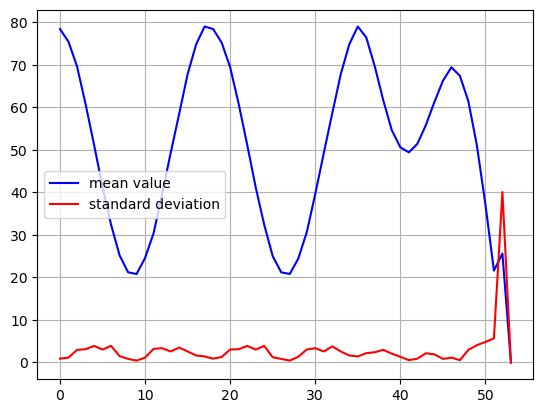

In [149]:
N = len(x_coords)
Nwindow = 5
mu = np.zeros((N//Nwindow)+1)
sigma = np.zeros((N//Nwindow)+1)

k = 0
n = Nwindow
while (n<N):
    mu[k] = np.mean(x_coords[n-Nwindow:n])
    sigma[k] = np.std(x_coords[n-Nwindow:n],ddof=1)
    k = k + 1
    n = n + Nwindow

plt.figure()
plt.plot(mu,'b',label='mean value')
plt.plot(sigma,'r',label='standard deviation')
plt.legend()
plt.grid('true')

Both the mean and std seems to stay within a certain limit, with the mean having a strong seasonal component.

Spike in std is where the UFO dissapears and appear at the other end of the frame.

P value:  0.032669619723561645


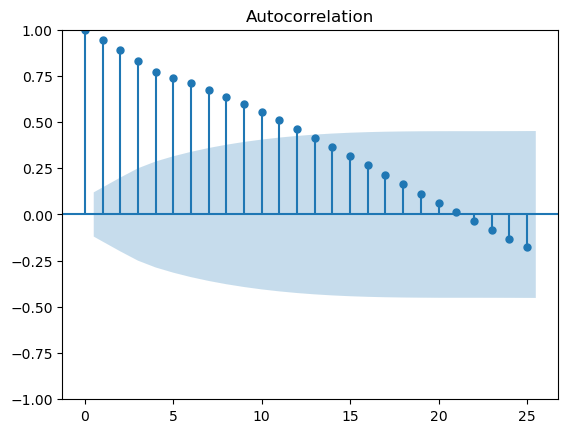

In [150]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(x_coords)

from statsmodels.tsa.stattools import adfuller
out = adfuller(x_coords)
print('P value: ', out[1])

With the auto correlation function having a slow decline it seems to be non stationary, although the p-value of the Dickey-Fuller Test, is within 95% CI (less than 0.05), thus we reject the null hypothesis and can conclude that the data is stationary.

#### General model identification

KeyboardInterrupt: 

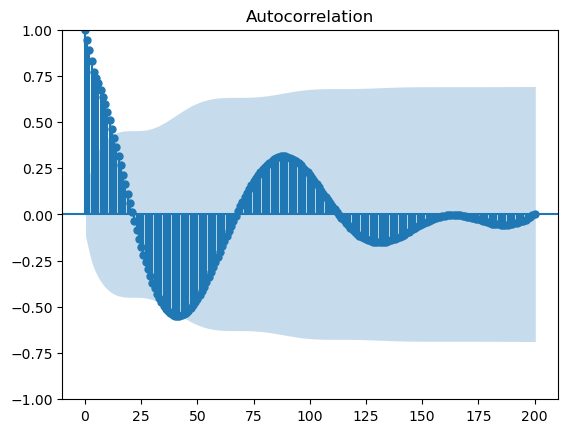

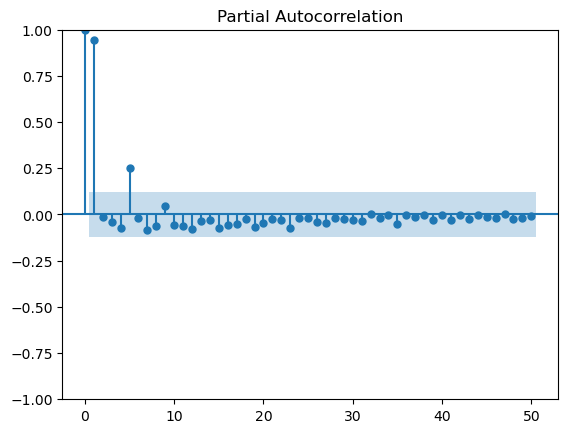

In [151]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_acf(x_coords, lags=200)
plot_pacf(x_coords, lags=50)

The auto correlation shows a very strong seasonal component, with a period of around 90 samples, that needs to be modelled for accurate prediction. 

#### Fit model

In [ ]:
y = x_coords
N1 = len(y)
Ntrain = int(N1*0.5)
print('Number of training samples: ',Ntrain)
y_train = y[0:Ntrain]
y_test = y[Ntrain:]

Number of training samples:  134


In [ ]:
from statsmodels.tsa.arima.model import ARIMA

p = 1
q = 1     #1 for first model

# ARMAmodel = ARIMA(y_train, order=(p, 0, q))
ARMAmodel = ARIMA(y_train,order=(1,0,1),seasonal_order=(1,0,1,90),trend='ct')
ARMAresults = ARMAmodel.fit()
print(ARMAresults.summary())
print('statsmodels coefficients: ',ARMAresults.params[1:3])

c:\Users\User\miniconda3\envs\signal3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\User\miniconda3\envs\signal3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                    SARIMAX Results                                     
Dep. Variable:                          x_coord   No. Observations:                  134
Model:             ARIMA(1, 0, 1)x(1, 0, 1, 90)   Log Likelihood                -225.499
Date:                          Sat, 25 May 2024   AIC                            464.999
Time:                                  15:18:26   BIC                            485.284
Sample:                                       0   HQIC                           473.242
                                          - 134                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         51.6909     29.614      1.745      0.081      -6.352     109.734
x1            -0.0067      0.039     -0.174      0.

#### Evaluate the model

Test for whiteness on residuals.

Shapiro-Wilk test
-----------------
Statistic =  0.5338193464111023 , p =  7.980618957830944e-19
Reject nul-hypothesis: sample not Gaussian
D'Agostino's K^2 test
---------------------
Statistic =  211.0325859187153 , p =  1.49574037500003e-46
Reject nul-hypothesis: sample not Gaussian


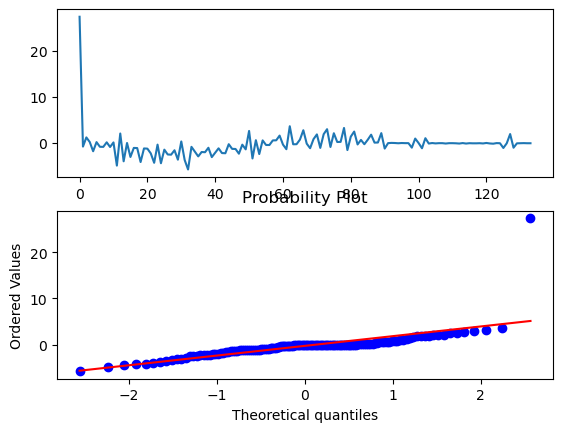

<Figure size 640x480 with 0 Axes>

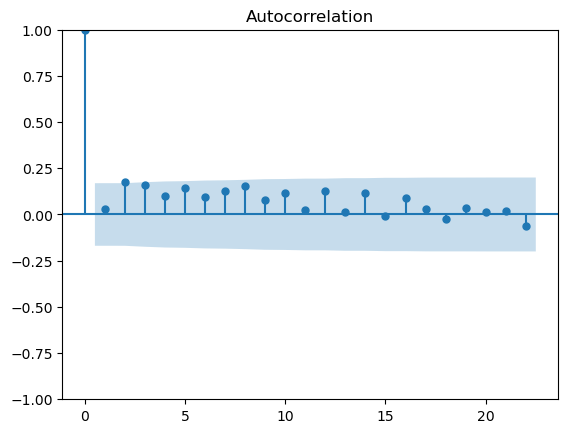

In [ ]:
residuals = ARMAresults.resid
from scipy import stats

plt.figure()
plt.tight_layout()
plt.subplot(2,1,1)
plt.plot(residuals)
plt.subplot(2,1,2)
stats.probplot(residuals,dist='norm',plot=plt)

plt.figure()
plot_acf(residuals)

alpha = 0.05

print('Shapiro-Wilk test')
print('-----------------')
stat,p = stats.shapiro(residuals)
print('Statistic = ',stat,', p = ',p)
if (p < alpha):
	print('Reject nul-hypothesis: sample not Gaussian')
else:
	print('Fail to reject H0: sample probably Gaussian')
#	----------------------------------------------------------------
print("D'Agostino's K^2 test")
print('---------------------')
stat,p = stats.normaltest(residuals)
print('Statistic = ',stat,', p = ',p)
if (p < alpha):
	print('Reject nul-hypothesis: sample not Gaussian')
else:
	print('Fail to reject H0: sample probably Gaussian')

Not gaussian, from 2 tests above.

#### Deploy model for prediction

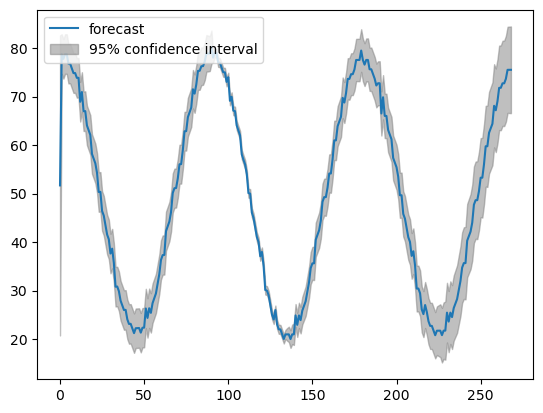

In [ ]:
from statsmodels.graphics.tsaplots import plot_predict

fig, ax = plt.subplots()
fig = plot_predict(ARMAresults, start=0, end=N1, ax=ax)
legend = ax.legend(loc="upper left")
lines = fig.axes[0].lines
predicted_values = lines[0].get_ydata()

#### Accuracy test

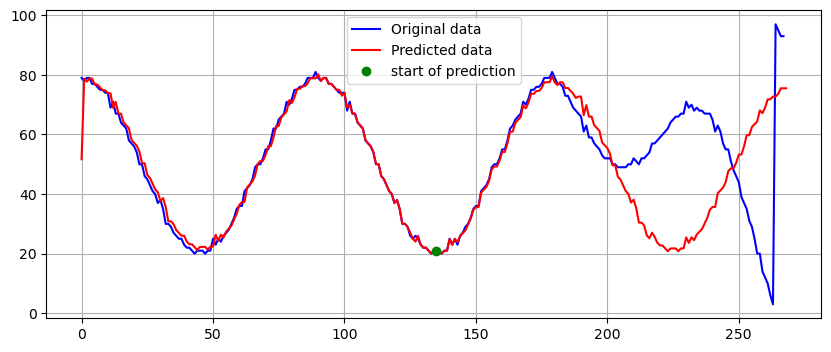

In [ ]:
t1 = np.arange(0, len(x_coords), 1)
t2 = np.arange(0, len(predicted_values), 1)
# Plot and compare the data
plt.figure(figsize=(10, 4))
plt.plot(t1, x_coords, 'b', label='Original data')
plt.plot(t2, predicted_values, 'r', label='Predicted data')
plt.plot(N_train, predicted_values[N_train+1], 'go', label = 'start of prediction')
plt.grid()
plt.legend()
plt.show()

In [ ]:
steps = [1, 5, 10, 15]

for i in steps:
    predicted_value = predicted_values[Ntrain+i]
    true_value = x_coords[Ntrain+i]
    abs_error = abs(predicted_value - true_value)
    rel_error = (abs(predicted_value - true_value) / true_value) * 100
    print('For frame ', i, ', Abs error: ', round(abs_error,2), 'pixels, Relative error: ', round(rel_error,2), '%')

For frame  1 , Abs error:  0.02 pixels, Relative error:  0.1 %
For frame  5 , Abs error:  0.01 pixels, Relative error:  0.06 %
For frame  10 , Abs error:  0.13 pixels, Relative error:  0.51 %
For frame  15 , Abs error:  0.36 pixels, Relative error:  1.02 %


### y-coordinates

Copy same code as x-coordinates